# 3. Cora dataset

<div class="alert alert-block alert-success">
<b>Question 23:</b> Idea 1

Use Graph Convolutional Networks [1]. What hyperparameters do you choose to get the optimal performance? How many layers did you choose?
</div>

In [ ]:
!pip install spektral    # dont mention version
!pip install Keras       # dont mention version
!pip install tensorflow  # dont mention version

In [ ]:
import numpy as np
import os
import networkx as nx
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from spektral.layers import GCNConv #previously it was GraphConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
all_data = []
all_edges = []

for root,dirs,files in os.walk('./cora'):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines())
        elif 'cites' in file:
            with open(os.path.join(root,file),'r') as f:
                all_edges.extend(f.read().splitlines())

all_data = shuffle(all_data,random_state=42)

In [ ]:
labels = []
nodes = []
X = []

for i,data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(elements[-1])
    X.append(elements[1:-1])
    nodes.append(elements[0])

X = np.array(X,dtype=int)
N = X.shape[0] 
F = X.shape[1]
print('X shape: ', X.shape)


#parse the edge
edge_list=[]
for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0],e[1]))

print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', F)
print('\nCategories: ', set(labels))

num_classes = len(set(labels))
print('\nNumber of classes: ', num_classes)

X shape:  (2708, 1433)

Number of nodes (N):  2708

Number of features (F) of each node:  1433

Categories:  {'Theory', 'Case_Based', 'Probabilistic_Methods', 'Rule_Learning', 'Genetic_Algorithms', 'Neural_Networks', 'Reinforcement_Learning'}

Number of classes:  7


In [ ]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)

A = nx.adjacency_matrix(G)

# module 'networkx' has no attribute 'info', which has been removed
# print('Graph info: ', nx.info(G)) 
# instead, use the following
print('Number of nodes', len(G.nodes))
print('Number of edges', len(G.edges))
print('Average degree', sum(dict(G.degree).values()) / len(G.nodes))

Number of nodes 2708
Number of edges 5278
Average degree 3.8980797636632203


In [ ]:
# get 20 train instances per class
# remaining instances are in validation and test set
train_num = 20
val_num = 500
test_num = 1000

label_counter = dict((l, 0) for l in labels)
train_idx = []

# get training set
for i in range(len(labels)):
    label = labels[i]
    if label_counter[label] < train_num:
        train_idx.append(i)
        label_counter[label]+=1
    if all(count == train_num for count in label_counter.values()):
        break

# get validation and test set
rest_idx = [x for x in range(len(labels)) if x not in train_idx]
val_idx = rest_idx[:val_num]
test_idx = rest_idx[val_num:(val_num+test_num)]

# set the mask
train_mask = np.zeros((N,), dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,), dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,), dtype=bool)
test_mask[test_idx] = True

In [ ]:
# convert the labels to one hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_encoded = to_categorical(labels_encoded)
classes = label_encoder.classes_

In [ ]:
# Parameters
channels = 16           
dropout = 0.5         
l2_reg = 5e-4           
learning_rate = 1e-2
epochs = 200    
es_patience = 10

# Model definition
A = GCNConv.preprocess(A).astype('f4')

X_in = Input(shape=(F, ))
fltr_in = Input((N, ), sparse=True)

dropout_1 = Dropout(dropout)(X_in)
graph_conv_1 = GCNConv(channels,
                       activation='relu',
                       kernel_regularizer=l2(l2_reg),
                       use_bias=False)([dropout_1, fltr_in])

dropout_2 = Dropout(dropout)(graph_conv_1)
graph_conv_2 = GCNConv(num_classes,
                       activation='softmax',
                       use_bias=False)([dropout_2, fltr_in])
                       
model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
    log_dir='./Tensorboard_GCN_cora',
)
callback_GCN = [tbCallBack_GCN]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1433)]       0           []                               
                                                                                                  
 dropout (Dropout)              (None, 1433)         0           ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 2708)]       0           []                               
                                                                                                  
 gcn_conv (GCNConv)             (None, 16)           22928       ['dropout[0][0]',                
                                                                  'input_2[0][0]']            

In [ ]:
# Train model
validation_data = ([X, A], labels_encoded, val_mask)
model.fit([X, A],
          labels_encoded,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,
          callbacks=[
              EarlyStopping(patience=es_patience,  restore_best_weights=True),
              tbCallBack_GCN
          ])

Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 0.1165 - acc: 0.1643 - val_loss: 0.3640 - val_acc: 0.3780
Epoch 2/200
1/1 [==============================] - 0s 245ms/step - loss: 0.1099 - acc: 0.2857 - val_loss: 0.3526 - val_acc: 0.5600
Epoch 3/200
1/1 [==============================] - 0s 239ms/step - loss: 0.1029 - acc: 0.5000 - val_loss: 0.3405 - val_acc: 0.6200
Epoch 4/200
1/1 [==============================] - 0s 246ms/step - loss: 0.0968 - acc: 0.7071 - val_loss: 0.3294 - val_acc: 0.6440
Epoch 5/200
1/1 [==============================] - 0s 268ms/step - loss: 0.0910 - acc: 0.7071 - val_loss: 0.3187 - val_acc: 0.6680
Epoch 6/200
1/1 [==============================] - 0s 357ms/step - loss: 0.0869 - acc: 0.7643 - val_loss: 0.3086 - val_acc: 0.6860
Epoch 7/200
1/1 [==============================] - 0s 256ms/step - loss: 0.0827 - acc: 0.7857 - val_loss: 0.2993 - val_acc: 0.7000
Epoch 8/200
1/1 [==============================] - 0s 225ms/step - loss: 0.0789 - acc:

In [ ]:
# Evaluate model
X_te = X[test_mask]
A_te = A[test_mask,:][:,test_mask]
y_te = labels_encoded[test_mask]

y_pred = model.predict([X_te, A_te], batch_size=N)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
print('GCN Classification Report: \n {}'.format(report))

1/1 [==============================] - 0s 98ms/step
GCN Classification Report: 
                         precision    recall  f1-score   support

            Case_Based       0.78      0.75      0.77       113
    Genetic_Algorithms       0.89      0.81      0.85       150
       Neural_Networks       0.88      0.76      0.81       306
 Probabilistic_Methods       0.80      0.80      0.80       167
Reinforcement_Learning       0.69      0.84      0.76        79
         Rule_Learning       0.56      0.79      0.65        62
                Theory       0.56      0.63      0.59       123

              accuracy                           0.76      1000
             macro avg       0.74      0.77      0.75      1000
          weighted avg       0.78      0.76      0.77      1000



<div class="alert alert-block alert-success">
<b>Answer 23:</b> I choose the following hyperparameters and with 2 layers of Graph Convolutional Networks (GCN) to get optimal performance:
<ul>  
  <li>channels = 16</li>
  <li>dropout = 0.5</li>
  <li>l2_reg = 0.0005</li>
  <li>learning_rate = 0.01</li>
  <li>epochs = 200</li>
  <li>es_patience = 10</li>
</ul>

</div>

<div class="alert alert-block alert-success">
<b>Question 24:</b> Idea 2

Extract structure-based node features using Node2Vec [2]. Briefly describe how Node2Vec finds node features. Choose your desired classifier (one of SVM, Neural Network, or Random Forest) and classify the documents using only Node2Vec (graph structure) features. Now classify the documents using only the 1433-dimensional text features. Which one outperforms? Why do you think this is the case? Combine the Node2Vec and text features and train your classifier on the combined features. What is the best classification accuracy you get (in terms of the percentage of test documents correctly classified)?
</div>

In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1 --ignore-requires-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.2/435.2 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.1/528.1 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.1 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

import os
import networkx as nx
import numpy as np
import pandas as pd

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph #feel free to use any other library of your choice
from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline

### Cora Dataset

In [ ]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load(largest_connected_component_only=True)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 5209

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5209]
        Weights: all 1 (default)
        Features: none


### Corpus generation using BiasedRandomWalk

In [ ]:
# get random walks using BiasedRandomWalk
rw = BiasedRandomWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=100, # maximum length of a random walk
    n=10,       # number of random walks per root node
    p=0.5,      # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,      # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 24850


### Representation Learning using Word2Vec

`Word2Vec` implementation in `Gensim` works with `str` tokens, but the graph has integer IDs, so they're converted to `str` here.

We set the dimensionality of the learned embedding vectors to 128.

In [ ]:
from gensim.models import Word2Vec

str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(
    str_walks, 
    vector_size=128, 
    window=5, 
    min_count=0, 
    sg=1, 
    workers=2, 
    epochs=1
)

# The embedding vectors can be retrieved from model.wv using the node ID as key.
print(model.wv["19231"].shape)

(128,)


### Visualise Node Embeddings

In [ ]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = node_subjects[[int(node_id) for node_id in node_ids]]

In [ ]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

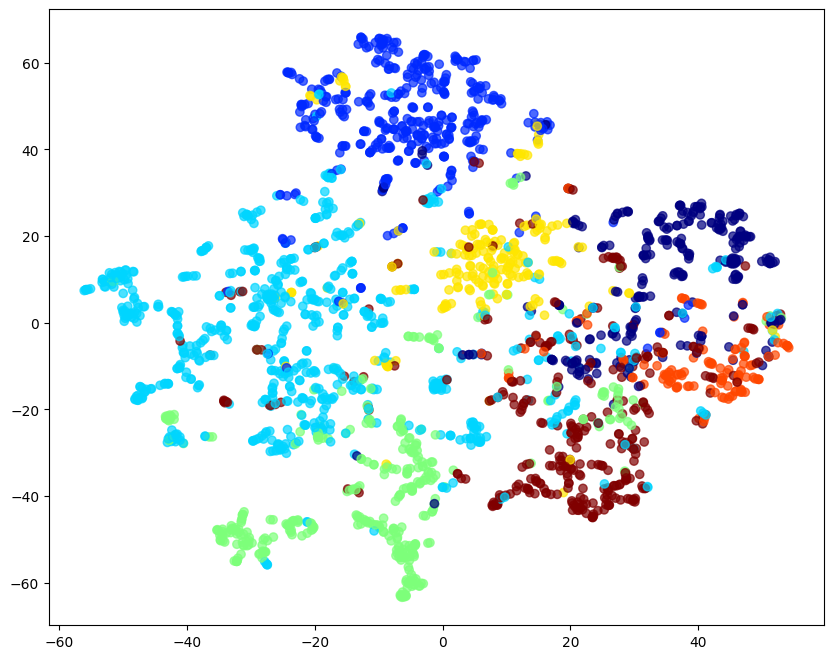

In [ ]:
# draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)

### CORA classification with Node2Vec preprocessing and SVM model

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.metrics import classification_report
from sklearn.svm import SVC

In [ ]:
# split the data, use 140 examples in train set 
X = node_embeddings
y = np.array(node_targets)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.0564)

print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (140, 128)
 y_train = (140,)
 X_test = (2345, 128)
 y_test = (2345,)


In [ ]:
# use SVM model, k-fold cross-validation for finding best gamma
best_score = 0
scores_list = []

for k in range(-3, 6+1):
    # SVM model
    gamma = 10**k
    svm = SVC(C=gamma, kernel='linear', probability=True, random_state=42)
    
    # k-fold cross-validation 
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(svm, X_train, y_train , cv=cv, scoring='accuracy')
    
    cur_score = scores.mean()
    scores_list.append(cur_score)

    if cur_score > best_score:
        best_score = cur_score
        best_gamma = gamma

print('The best gamma for SVM is {} with the {:5.2f}% accuracy\n'.format(best_gamma, 
                                                                         best_score*100))

# SVM with best gamma
svm_best = SVC(C=best_gamma, kernel='linear', probability=True, random_state=42)
svm_best = svm_best.fit(X_train, y_train)
svm_best_pred = svm_best.predict(X_test)
svm_best_pred_prob = svm_best.predict_proba(X_test)[::, 1]

# report
report = classification_report(y_test, svm_best_pred, target_names=classes)
print('SVM Classification Report: \n {}'.format(report))

The best gamma for SVM is 0.1 with the 67.86% accuracy

SVM Classification Report: 
                         precision    recall  f1-score   support

            Case_Based       0.79      0.71      0.74       269
    Genetic_Algorithms       0.88      0.88      0.88       379
       Neural_Networks       0.70      0.80      0.75       688
 Probabilistic_Methods       0.75      0.74      0.74       359
Reinforcement_Learning       0.81      0.71      0.76       204
         Rule_Learning       0.78      0.36      0.49       125
                Theory       0.64      0.68      0.66       321

              accuracy                           0.75      2345
             macro avg       0.76      0.70      0.72      2345
          weighted avg       0.75      0.75      0.74      2345



### CORA classification with 1433-dimensional text features and SVM model

In [ ]:
all_data = []
all_edges = []

for root,dirs,files in os.walk('./cora'):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines())
        elif 'cites' in file:
            with open(os.path.join(root,file),'r') as f:
                all_edges.extend(f.read().splitlines())

all_data = shuffle(all_data,random_state=42)

labels = []
nodes = []
text_features = []

for i,data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(elements[-1])
    text_features.append(elements[1:-1])
    nodes.append(elements[0])

In [ ]:
# get corresponding 2485 nodes (node_ids from previous part) in GCC from original 2708 nodes
idx = [nodes.index(node) for node in node_ids]
labels = np.array(labels)[idx]
text_features = np.array(text_features)[idx]

# split data, 140 samples for train
X_train, X_test, y_train, y_test = train_test_split(text_features, labels, train_size=0.0564)

print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

Array shapes:
 X_train = (140, 1433)
 y_train = (140,)
 X_test = (2345, 1433)
 y_test = (2345,)


In [ ]:
best_gamma = 0.1

# SVM with best gamma
svm_best = SVC(C=best_gamma, kernel='linear', probability=True, random_state=42)
svm_best = svm_best.fit(X_train, y_train)
svm_best_pred = svm_best.predict(X_test)
svm_best_pred_prob = svm_best.predict_proba(X_test)[::, 1]

# report
report = classification_report(y_test, svm_best_pred, target_names=classes)
print('SVM Classification Report: \n {}'.format(report))

SVM Classification Report: 
                         precision    recall  f1-score   support

            Case_Based       0.56      0.41      0.48       269
    Genetic_Algorithms       0.72      0.75      0.74       375
       Neural_Networks       0.53      0.85      0.65       690
 Probabilistic_Methods       0.62      0.39      0.48       357
Reinforcement_Learning       0.68      0.48      0.57       200
         Rule_Learning       0.00      0.00      0.00       128
                Theory       0.52      0.44      0.48       326

              accuracy                           0.58      2345
             macro avg       0.52      0.48      0.48      2345
          weighted avg       0.56      0.58      0.55      2345



### Combine the Node2Vec and text features and train your classifier on the combined features

In [ ]:
# Node2Vec of GCC - X, y = node_embeddings (128), np.array(node_targets)
# Original of GCC - X, y = text_features (1433), labels

# make sure both dataset are aligned in the same order
assert all(np.array(node_targets) == labels), "GT not aligned!"

# combine
X = np.hstack([node_embeddings, text_features])
y = labels

# split data, 140 samples for train
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.0564)

print(
    "Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}\n".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape
    )
)

# SVM with best gamma
best_gamma = 0.1
svm_best = SVC(C=best_gamma, kernel='linear', probability=True, random_state=42)
svm_best = svm_best.fit(X_train, y_train)
svm_best_pred = svm_best.predict(X_test)
svm_best_pred_prob = svm_best.predict_proba(X_test)[::, 1]

# report
report = classification_report(y_test, svm_best_pred, target_names=classes)
print('SVM Classification Report: \n {}'.format(report))

Array shapes:
 X_train = (140, 1561)
 y_train = (140,)
 X_test = (2345, 1561)
 y_test = (2345,)

SVM Classification Report: 
                         precision    recall  f1-score   support

            Case_Based       0.83      0.73      0.78       270
    Genetic_Algorithms       0.91      0.90      0.91       376
       Neural_Networks       0.75      0.83      0.79       690
 Probabilistic_Methods       0.74      0.82      0.78       360
Reinforcement_Learning       0.75      0.78      0.76       202
         Rule_Learning       0.91      0.52      0.66       123
                Theory       0.71      0.62      0.66       324

              accuracy                           0.78      2345
             macro avg       0.80      0.74      0.76      2345
          weighted avg       0.79      0.78      0.78      2345



<div class="alert alert-block alert-success">
<b>Answer 24:</b> Node2Vec finds node features by generating random walks in the graph, training a Skip-gram model on these walks to learn node embeddings, and then extracting the learned embeddings as the node features. These features capture the structural properties of the graph and can be used for various downstream tasks, such as node classification or link prediction.

Here, I choose SVM as classifier and based on the results shown above, the classifier trained on Node2Vec (graph structure) features achieves an accuracy of 75%, which outperforms the one trained on 1433-dimensional text features with only 58% accuracy. This is expected since Node2Vec capture the structural properties of the graph and generate the representative node embeddings, which provide more information than text features of each node itself. Therefore, it yields better performance.

Moreover, by combining these two types of features, i.e. Node2Vec and text features, the highest accuracy of 78% is achieved.
</div>

<div class="alert alert-block alert-success">
<b>Question 25:</b> Idea 3

We can find the personalized PageRank of each document in seven different runs, one per class. In each run, select one of the classes and take the 20 seed documents of that class. Then, perform a random walk with the following customized properties: 


<ul>  
  <li>(a) teleportation takes the random walker to one of the seed documents of that class (with a uniform probability of 1/20 per seed document). Vary the teleportation probability in {0, 0.1, 0.2}. </li>
  <li>(b) the probability of transitioning to neighbors is not uniform among the neighbors. Rather, it is proportional to the cosine similarity between the text features of the current node and the next neighboring node.</li>
</ul>

Repeat part b for every teleportation probability in part a.
Run the PageRank only on the GCC. for each seed node, do 1000 random walks. Maintain a class-wise visited frequency count for every unlabeled node. The predicted class for that unlabeled node is the class which lead to maximum visits to that node. Report accuracy and f1 scores.


</div>

In [1]:
import numpy as np
import os
import networkx as nx
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from numpy import dot
from numpy.linalg import norm


from collections import Counter
import matplotlib.pyplot as plt
# !unzip "cora (extract.me).zip"

In [2]:
all_data = []
all_edges = []

for root,dirs,files in os.walk('./cora'):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines())
        elif 'cites' in file:
            with open(os.path.join(root,file),'r') as f:
                all_edges.extend(f.read().splitlines())
                
# random_state = 42
# all_data = shuffle(all_data,random_state=random_state)

In [3]:
categories =  ['Reinforcement_Learning', 'Theory', 'Case_Based', 'Genetic_Algorithms', 
               'Probabilistic_Methods', 'Neural_Networks', 'Rule_Learning']
sorted(categories)
label_encoder = {}
i = 0
for cat in sorted(categories):
  label_encoder[cat] = i
  i +=1
label_encoder

{'Case_Based': 0,
 'Genetic_Algorithms': 1,
 'Neural_Networks': 2,
 'Probabilistic_Methods': 3,
 'Reinforcement_Learning': 4,
 'Rule_Learning': 5,
 'Theory': 6}

In [4]:
# parse the data
labels = []
nodes = []
X = []
element_to_ind  = {}

for i,data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(label_encoder[elements[-1]])
    X.append(elements[1:-1])
    nodes.append(elements[0])
    element_to_ind[elements[0]]= i
X = np.array(X,dtype=int)
N = X.shape[0] # the number of nodes
F = X.shape[1] # the size of node features
print('X shape: ', X.shape)


# parse the edge
edge_list=[]
for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0],e[1]))

print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', F)
print('\nCategories: ', set(labels))

num_classes = len(set(labels))
print('\nNumber of classes: ', num_classes)

X shape:  (2708, 1433)

Number of nodes (N):  2708

Number of features (F) of each node:  1433

Categories:  {0, 1, 2, 3, 4, 5, 6}

Number of classes:  7


In [5]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)
G = nx.relabel_nodes(G, element_to_ind)

# module 'networkx' has no attribute 'info', which has been removed
# print('Graph info: ', nx.info(G)) 
# instead, use the following
print('Number of nodes', len(G.nodes))
print('Number of edges', len(G.edges))
print('Average degree', sum(dict(G.degree).values()) / len(G.nodes))

Number of nodes 2708
Number of edges 5278
Average degree 3.8980797636632203


In [6]:
nodes = list(G.nodes)
print(len(nodes))
list(G.neighbors(0))

2708


[258, 544, 8, 435, 14]

In [7]:
df = pd.DataFrame(list(zip(nodes, labels, X)), columns=['node', 'label','features'])
print(len(df))
df.head()

2708


,node,label,features
0,0,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,2,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])
gcc_nodes = list(G.nodes)

In [9]:
df = df.loc[df['node'].isin(gcc_nodes)]
df['node'] = list(range(len(df))) # rename nodes 
df.head()

<ipython-input-9-67861b7df33b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['node'] = list(range(len(df))) # rename nodes


,node,label,features
0,0,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,2,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [10]:
train = df.groupby('label', group_keys=False).apply(lambda x: x.sample(20))
G = nx.relabel_nodes(G, df['node'])

In [30]:
def create_transition_matrix(g):
    vs = list(g.nodes)
    n = len(vs)
    adj = nx.adjacency_matrix(g)
    transition_matrix = adj/adj.sum(axis=1)

    return transition_matrix


def random_walk(g, num_steps, start_node, transition_matrix = None):
  if transition_matrix is None:
    transition_matrix = create_transition_matrix(g)
  
  # perform a random walk 
  walked_nodes = np.zeros(num_steps)
  v = start_node
  for i in range(num_steps):
    PMF = transition_matrix[:, v]
    v = int(np.random.choice(len(g.nodes), size=1, p=PMF))
    walked_nodes[i] = v

  return v


seeds_dict = {predicted:list(train[train['label'] == predicted]['node']) 
              for predicted in range(7)}


def random_walk_with_teleportation(g, num_steps, start_node, tp, 
                                   predicted, transition_matrix = None):
  if transition_matrix is None:
    transition_matrix = create_transition_matrix(g)
  
  # perform a random walk 
  walked_nodes = np.zeros(num_steps)
  v = start_node
  for i in range(num_steps):
    if (np.random.random() > tp):
      # no teleportation
      PMF = transition_matrix[:, v]
      v = int(np.random.choice(len(g.nodes), 1, p=PMF))
    else:
      # with teleportation (equal distribution)
      # you can only teleport to a node belonging to the same class as seed documents
      v = int(np.random.choice(seeds_dict[predicted], size=1))
  
    walked_nodes[i] = v

  return v

In [ ]:
# pagerank. NO teleportation, NO tfidf. 

transition_matrix = create_transition_matrix(G)

num_samples = 1000  
num_walk_steps = 100

visiting_freq_label = []
for i in range(transition_matrix.shape[0]):
  visiting_freq_label.append([0,0,0,0,0,0,0])

visiting_freq = [0 for i in range(transition_matrix.shape[0])]

for train_node,predicted in zip(train['node'],train['label']):
  # print (train_node,predicted)
  for i in range(num_samples):
      start_point = train_node
      end_node = random_walk(G, num_walk_steps, start_point, transition_matrix)
      visiting_freq_label[end_node][predicted] += 1
      visiting_freq[end_node] +=1

count = 0 #these many nodes remain unvisited. 

for vf in visiting_freq:
  if vf ==0:
    count+=1
print('unvisited = ', count)
visiting_freq_label = np.asarray(visiting_freq_label)
preds = np.argmax(visiting_freq_label,axis = 1)
print(classification_report(df['label'], preds))
accuracy_score(df['label'], preds)

unvisited =  1
              precision    recall  f1-score   support

           0       0.30      0.52      0.38       285
           1       0.43      0.50      0.46       406
           2       0.50      0.25      0.34       726
           3       0.72      0.57      0.64       379
           4       0.12      0.18      0.14       214
           5       0.07      0.16      0.10       131
           6       0.28      0.21      0.24       344

    accuracy                           0.35      2485
   macro avg       0.35      0.34      0.33      2485
weighted avg       0.41      0.35      0.37      2485



0.35492957746478876

In [31]:
# pagerank. WITH telportation, without tfidf 

transition_matrix = create_transition_matrix(G)

num_samples = 1000  
num_walk_steps = 100

tps = [0, 0.1, 0.2]

for tp in tps:
  visiting_freq_label = []
  for i in range(transition_matrix.shape[0]):
    visiting_freq_label.append([0,0,0,0,0,0,0])

  visiting_freq = [0 for i in range(transition_matrix.shape[0])]

  for train_node, predicted in zip(train['node'], train['label']):
    # print (train_node,predicted)
    for i in range(num_samples):
        start_point = train_node
        end_node = random_walk_with_teleportation(G, num_walk_steps, start_point, 
                                                  tp, predicted, transition_matrix)
        visiting_freq_label[end_node][predicted] += 1
        visiting_freq[end_node] +=1

  count = 0 #these many nodes remain unvisited. 

  for vf in visiting_freq:
    if vf ==0:
      count+=1
  print("\nExperiment with telportation probability: {}".format(tp))
  print('- unvisited = ', count)
  visiting_freq_label = np.asarray(visiting_freq_label)
  preds = np.argmax(visiting_freq_label,axis = 1)
  print(classification_report(df['label'], preds))
  accuracy_score(df['label'], preds)


Experiment with telportation probability: 0
- unvisited =  0
              precision    recall  f1-score   support

           0       0.31      0.49      0.38       285
           1       0.48      0.55      0.52       406
           2       0.55      0.29      0.38       726
           3       0.57      0.56      0.56       379
           4       0.10      0.14      0.12       214
           5       0.10      0.22      0.14       131
           6       0.25      0.18      0.21       344

    accuracy                           0.37      2485
   macro avg       0.34      0.35      0.33      2485
weighted avg       0.41      0.37      0.37      2485


Experiment with telportation probability: 0.1
- unvisited =  30
              precision    recall  f1-score   support

           0       0.62      0.74      0.67       285
           1       0.81      0.84      0.83       406
           2       0.87      0.52      0.65       726
           3       0.76      0.81      0.78       379
     

In [70]:
vs = list(G.nodes)
n = len(vs)
adj = nx.adjacency_matrix(G)
transition = np.zeros((len(G.nodes), len(G.nodes)))

#for n1 in nodes:
  #for n2 in nodes:
    # if there is an edge between n1 and n2:
      # cos_sim = compute cosine similarity between features of n1 and n2
      # transition[n1,n2] = np.exp(cos_sim) #neumerator of softmax. #why do we need softmax?  
#divide the values in transition by denominator of softmax. how will you do this? 

for i in range(n):
  A = df['features'].to_numpy()[i]
  for j in range(n):
    B = df['features'].to_numpy()[j]
    if adj[i, j] == 1:
      cos_sim = np.dot(A, B)/(np.linalg.norm(A)*np.linalg.norm(B))
      transition[i, j] = np.exp(cos_sim)

transition /= np.sum(transition, axis=0, keepdims=True)

In [73]:
# pagerank. Without teleportation. WITH TFIDF 

transition_matrix = transition

# perfrom pagerank using our tf_idf based transition matrix
# use randon walk without teleporation 
# get metrics

num_samples = 1000  
num_walk_steps = 100

visiting_freq_label = []
for i in range(transition_matrix.shape[0]):
  visiting_freq_label.append([0,0,0,0,0,0,0])

visiting_freq = [0 for i in range(transition_matrix.shape[0])]

for train_node,predicted in zip(train['node'],train['label']):
  # print (train_node,predicted)
  for i in range(num_samples):
      start_point = train_node
      end_node = random_walk(G, num_walk_steps, start_point, transition_matrix)
      visiting_freq_label[end_node][predicted] += 1
      visiting_freq[end_node] +=1

count = 0 #these many nodes remain unvisited. 

for vf in visiting_freq:
  if vf ==0:
    count+=1
print("Pagerank (without teleportation but with TFIDF)")
print('unvisited = ', count)
visiting_freq_label = np.asarray(visiting_freq_label)
preds = np.argmax(visiting_freq_label,axis = 1)
print(classification_report(df['label'], preds))
accuracy_score(df['label'], preds)

Pagerank (without teleportation but with TFIDF)
unvisited =  0
              precision    recall  f1-score   support

           0       0.35      0.54      0.42       285
           1       0.51      0.55      0.53       406
           2       0.60      0.32      0.42       726
           3       0.59      0.57      0.58       379
           4       0.13      0.18      0.15       214
           5       0.14      0.31      0.20       131
           6       0.28      0.22      0.25       344

    accuracy                           0.40      2485
   macro avg       0.37      0.39      0.36      2485
weighted avg       0.45      0.40      0.40      2485



0.39517102615694166

In [74]:
#pagerank. WITH teleportation WITH TFIDF
transition_matrix = transition

#same as above, except use random walk with teleportation 
#get metrics

num_samples = 1000  
num_walk_steps = 100

tps = [0, 0.1, 0.2]

for tp in tps:
  visiting_freq_label = []
  for i in range(transition_matrix.shape[0]):
    visiting_freq_label.append([0,0,0,0,0,0,0])

  visiting_freq = [0 for i in range(transition_matrix.shape[0])]

  for train_node, predicted in zip(train['node'], train['label']):
    # print (train_node,predicted)
    for i in range(num_samples):
        start_point = train_node
        end_node = random_walk_with_teleportation(G, num_walk_steps, start_point, 
                                                  tp, predicted, transition_matrix)
        visiting_freq_label[end_node][predicted] += 1
        visiting_freq[end_node] +=1

  count = 0 #these many nodes remain unvisited. 

  for vf in visiting_freq:
    if vf ==0:
      count+=1
  print("Pagerank (with teleportation and with TFIDF)")
  print("\nExperiment with telportation probability: {}".format(tp))
  print('- unvisited = ', count)
  visiting_freq_label = np.asarray(visiting_freq_label)
  preds = np.argmax(visiting_freq_label,axis = 1)
  print(classification_report(df['label'], preds))
  accuracy_score(df['label'], preds)

Pagerank (with teleportation and with TFIDF)

Experiment with telportation probability: 0
- unvisited =  0
              precision    recall  f1-score   support

           0       0.35      0.55      0.43       285
           1       0.46      0.52      0.49       406
           2       0.59      0.33      0.42       726
           3       0.54      0.54      0.54       379
           4       0.13      0.16      0.14       214
           5       0.10      0.22      0.14       131
           6       0.31      0.23      0.26       344

    accuracy                           0.38      2485
   macro avg       0.36      0.36      0.35      2485
weighted avg       0.43      0.38      0.39      2485

Pagerank (with teleportation and with TFIDF)

Experiment with telportation probability: 0.1
- unvisited =  19
              precision    recall  f1-score   support

           0       0.62      0.75      0.68       285
           1       0.82      0.84      0.83       406
           2       0.88

<div class="alert alert-block alert-success">
<b>Answer 25:</b> The accuracy and f1 scores for each eperiment with/without teleportation or TFIDF are reported above. Overall, the best model here is with teleportation at a probability of 10% and with TFIDF, which results in highest accuracy of 70%. Moreover, adding teleportation or TFIDF, in general, increases the model performance, which can be proven by the experiments above. 

As for the question asked in calculating the probability of transitioning to each neighbor, we need softmax because it is crucial for transforming model outputs into meaningful probabilities, enabling multiclass classification, facilitating the training process, and supporting gradient computation for efficient learning as well as avoding exploding gradients. To compute this, I first utilize the exponetial function to convert each cosine similarity values in transition matrix and then apply vectorization technique to divide the values in each column of transition matrix by the corresponding denominator, which is the sum of that column.

</div>